## Quickstart with the active learning module

[Active learning]( https://en.wikipedia.org/wiki/Active_learning_(machine_learning) ) is a method that aims to collect and labelled new data in order to improve the machine learning model. Based on a predefined heuristic strategy, a certain number of data will be annotated and used to re-train the model. 
In pyrelational, we use: 
- an active learning ``strategy``, that query new data points based on specific selection criterion;
- a ``model manager`` that takes in input an uninstantiated ML model and a set of arguments (ie: the number of epochs) used for training;
- a ``data_manager`` that will update, after each query, the pool of labelled and unlabelled data; 
- a ``pipeline`` that aims to manage the strategy, the model and the data manager together.

## The dataset

We will use the sklearn [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) where each datapoint is a 8x8 image of a digit that we aim to classify with a neural network.

In [81]:
import torch
from torchvision import datasets, transforms
from pyrelational.data import DataManager

# creating the dataset with pytorch
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
dataset = [dataset[i] for i in range(10000)]
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [9000, 500, 500])
train_indices = train_ds.indices
val_indices = val_ds.indices
test_indices = test_ds.indices

# creating the data manager
data_manager = DataManager(
    dataset=dataset,
    train_indices=train_indices,
    validation_indices=val_indices,
    test_indices=test_indices,
    loader_batch_size=1000,
)

## The model

The model here is build with the [Pytorch Lightning module](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html). 

In [82]:
from pyrelational.models import LightningMCDropoutModel
from examples.utils.ml_models import MnistClassification  # noqa: E402

model = LightningMCDropoutModel(
    model_class=MnistClassification, 
    model_config={"dropout": 0.2}, 
    trainer_config={"epochs": 4})

## The query strategy and the active learning loop


In [83]:
%%capture

from pyrelational.pipeline import Pipeline
from pyrelational.strategies.classification import (
    LeastConfidenceStrategy,
    MarginalConfidenceStrategy,
    RatioConfidenceStrategy,
    EntropyClassificationStrategy,
)

query = dict()
strategies = [LeastConfidenceStrategy,
                 MarginalConfidenceStrategy, 
                 RatioConfidenceStrategy, 
                 EntropyClassificationStrategy]

for strategy in strategies:
    # the data manager is reinitialized for each strategy
    data_manager = DataManager(
        dataset=dataset,
        train_indices=train_indices,
        validation_indices=val_indices,
        test_indices=test_indices,
        loader_batch_size=1000,
    )
    pipeline = Pipeline(data_manager=data_manager, model=model, strategy=strategy())
    pipeline.full_active_learning_run(num_annotate=1000)
    query[strategy.__name__] = pipeline


In [84]:
# print performance after each iteration for one strategy
query['MarginalConfidenceStrategy'].performance_history()

,Iteration,test_accuracy,test_loss
0,0,0.464,2.071307
1,1,0.346,1.812563
2,2,0.458,1.549991
3,3,0.560,1.212463
4,4,0.700,0.951194
5,5,0.732,0.913015
6,6,0.720,0.835431
7,7,0.716,0.797086
8,8,0.688,0.769976
9,9,0.752,0.741797


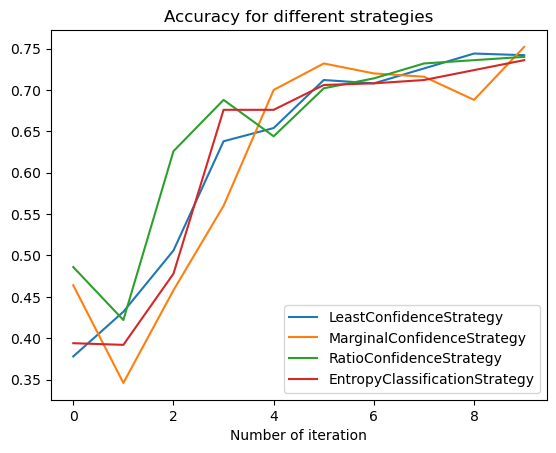

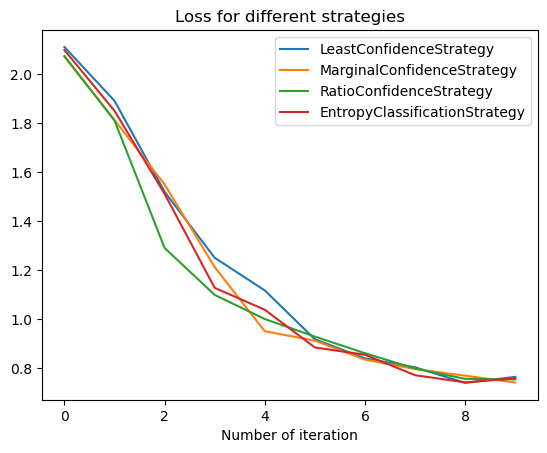

In [86]:
import matplotlib.pyplot as plt

for strategy in strategies :
    df = query[strategy.__name__].performance_history()
    plt.plot(df['test_accuracy'], label=strategy.__name__)
    plt.legend()
    plt.xlabel('Number of iteration')
    plt.title('Accuracy for different strategies')
plt.show()

for strategy in strategies :
    df = query[strategy.__name__].performance_history()
    plt.plot(df['test_loss'], label=strategy.__name__)
    plt.legend()
    plt.xlabel('Number of iteration')
    plt.title('Loss for different strategies')
plt.show()